<a href="https://colab.research.google.com/github/avkornaev/Sleep_Stages/blob/main/SleepStages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Instal Libraries

In [42]:
!pip install pytorch-lightning clearml

In [43]:
# ---------------------------
# 1. Imports & Environment Setup
# ---------------------------
import os
import shutil  # Add this line
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from typing import Optional, List, Dict, Tuple
from collections import defaultdict
from clearml import Task
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt  # Add this
import seaborn as sns            # Add this

import torchaudio  # For audio-specific augmentations
import random
from torch.utils.data import WeightedRandomSampler

# Set and Initialize

In [44]:
# Set up reproducibility
SEED = 42
pl.seed_everything(SEED)
torch.set_float32_matmul_precision('high')

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [45]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [46]:
DATASET = 'Sleep_Stages' # dataset with the real-world noise
#Clone the GitHub repository
repo_url = "https://github.com/avkornaev/Sleep_Stages"  # Replace with your repo URL
!git clone {repo_url}

#Navigate to the data folder
repo_name = repo_url.split("/")[-1].replace(".git", "")  # Extract repo name
data_dir = os.path.join(repo_name, "data")  # Replace "data" with your folder name
# os.chdir(data_dir)  # Change working directory to the data folder

# Verify the data directory
if os.path.exists(data_dir):
    print(f"Data directory found: {data_dir}")
else:
    print(f"Data directory not found: {data_dir}")

fatal: destination path 'Sleep_Stages' already exists and is not an empty directory.
Data directory found: Sleep_Stages/data


In [47]:
# ---------------------------
# 2. Configuration Constants
# ---------------------------
CONFIG = {
    "data_dir": "Sleep_Stages/data",
    "checkpoint_path": "saved_models/",
    "batch_size": 128,
    "window_size": 600,
    "learning_rate": 1e-3,
    "max_epochs": 2,
    "num_workers": 2,
    'focal_gamma': 2.0,  # Adjust based on imbalance severity
    'augment_minority': True,
    'batch_sampler': 'weighted'
}
MINORITY_CLASSES = ['R']

# Funcitons

Loading raw data...
Common labels: ['N2', 'R']


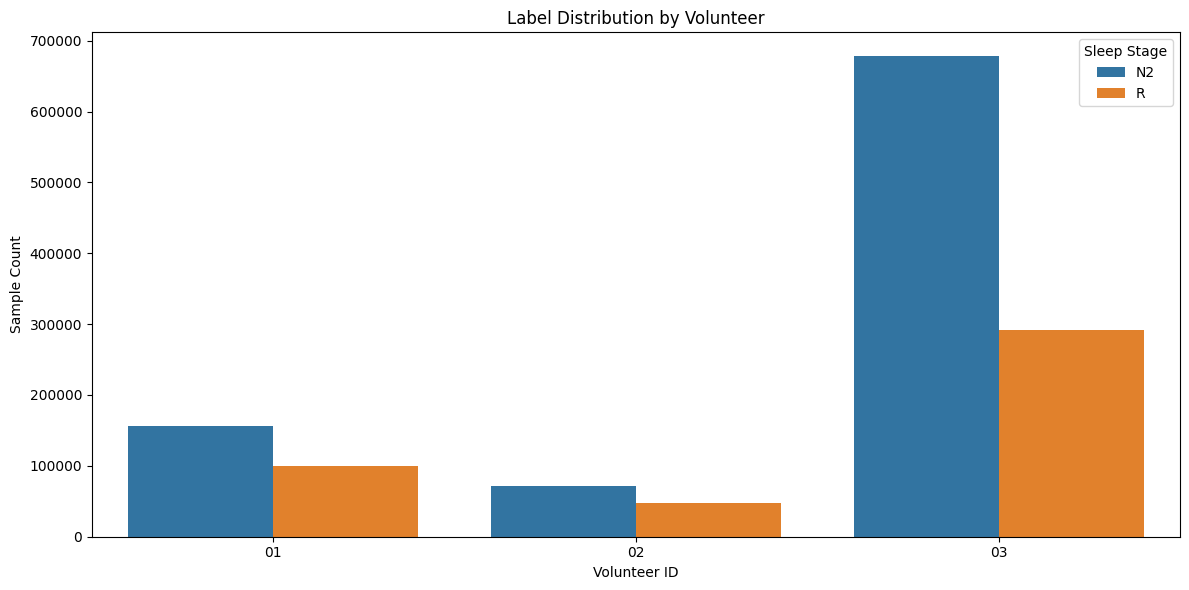

<ipython-input-48-f9f2f52739bc>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-value', y='Feature', data=feat_importance, palette='viridis')


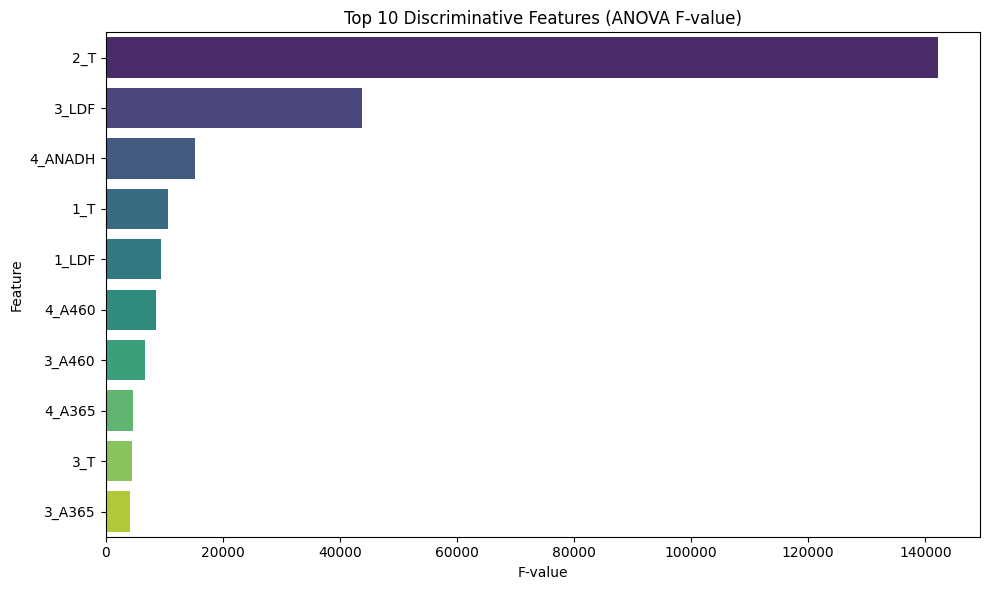

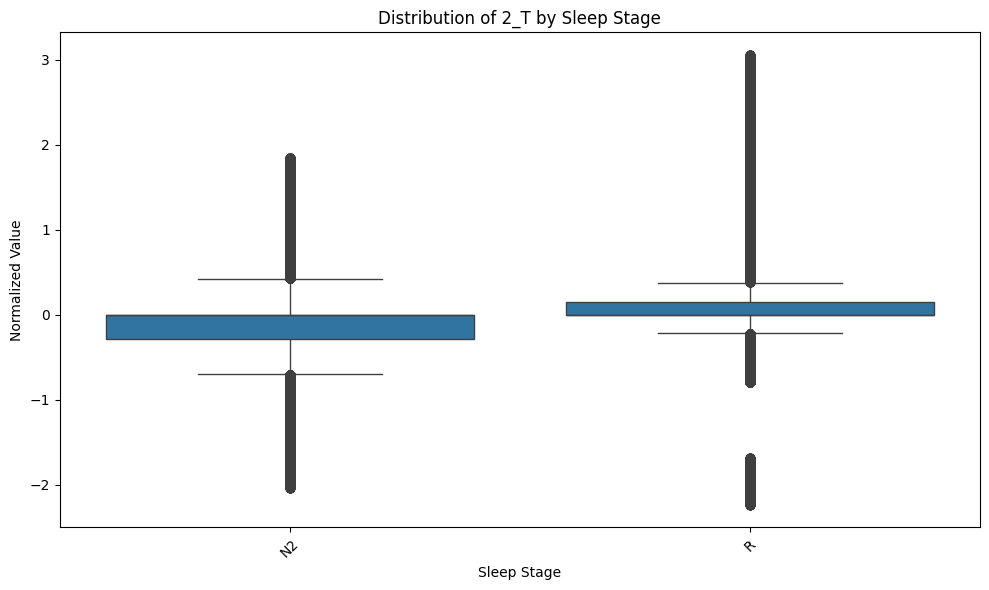

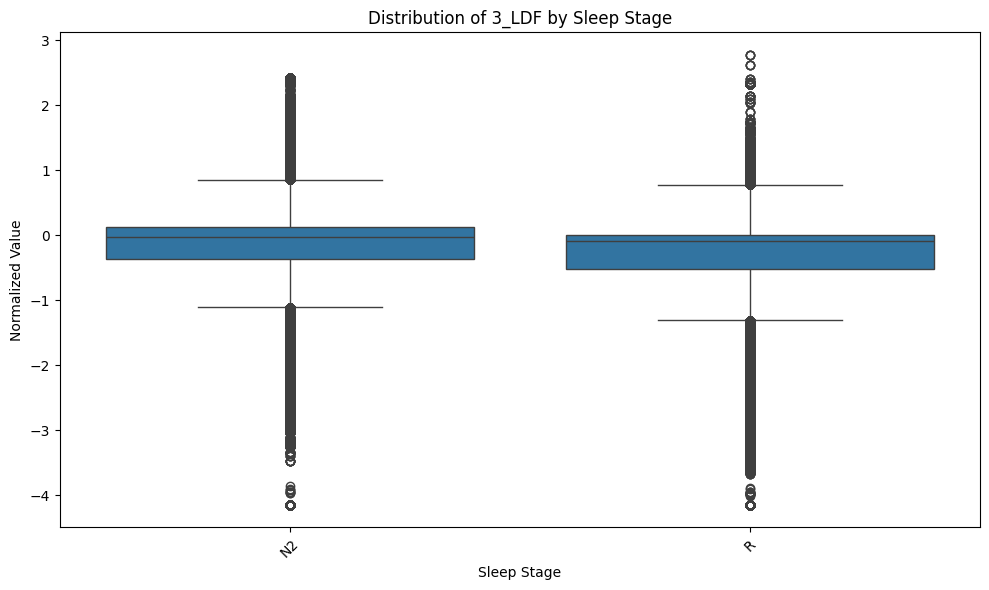

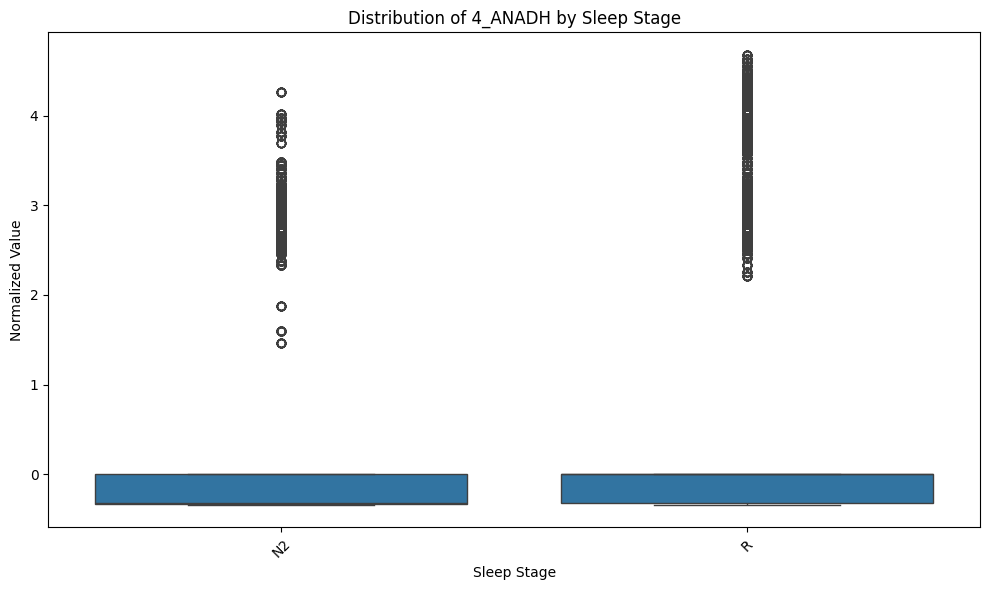


Preprocessed Data Sample:


,1_LDF,1_T,1_A365,1_A460,1_ANADH,2_LDF,2_T,2_A365,2_A460,2_ANADH,...,3_T,3_A365,3_A460,4_LDF,4_T,4_A365,4_A460,4_ANADH,volunteer,label
957285,-1.331664,1.161126,-0.029562,-0.171642,-0.175937,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,03,R
1255426,-0.556995,1.218329,0.210299,-0.713961,-0.971283,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.543740,-0.459262,-0.296217,0.000000,0.000000,0.000000,0.00000,0.000000,03,N2
602751,-0.513958,-0.783709,0.570090,0.448151,0.237088,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060543,-0.459262,-0.296217,0.000000,0.000000,0.000000,0.00000,0.000000,03,N2
795243,0.000000,0.000000,0.000000,0.000000,0.000000,0.994905,1.386341,0.495309,0.438668,-0.429169,...,0.004792,-0.459262,-0.296217,1.381911,0.821113,-0.297802,-0.61385,-0.325289,03,N2
160881,1.107109,1.118227,0.869915,0.293202,-0.102932,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,01,N2



LOSO Example: Training on 3630 samples, Validating on 852 samples


In [48]:
# ---------------------------
# 3. Data Preprocessing Block (Fixed)
# ---------------------------
def load_and_preprocess_data(directory: str) -> Tuple[pd.DataFrame, Dict[str, tuple], List[str], Dict[str, float]]:
    """Robust data loader with class weight calculation"""
    # Define column titles based on the sensor specifications
    column_titles = [
        '1_LDF', '1_T', '1_A365', '1_A460', '1_ANADH',
        '2_LDF', '2_T', '2_A365', '2_A460', '2_ANADH',
        '3_LDF', '3_T', '3_A365', '3_A460',
        '4_LDF', '4_T', '4_A365', '4_A460', '4_ANADH'
    ]

    # Define validation constraints for each feature type
    constraints = {
        'LDF': {'min': 0, 'max': 100},
        'T': {'min': 25, 'max': 45},
        'A365': {'min': 0, 'max': 300},
        'A460': {'min': 0, 'max': 300},
        'ANADH': {'min': 0, 'max': None}  # Only positive values required
    }

    # First pass: Load raw data and calculate global statistics
    raw_data = defaultdict(list)
    all_features = []
    label_sets = defaultdict(set)

    print("Loading raw data...")
    for filename in os.listdir(directory):
        if not filename.startswith("Vol_") or not filename.endswith(".csv.gz"):
            continue

        try:
            # Load data with column names
            df = pd.read_csv(os.path.join(directory, filename),
                           compression='gzip', skiprows=1, header=None,
                           dtype={i: np.float32 for i in range(19)})
            df.columns = column_titles + ["label"]

            # Validate and clean each feature column
            for col in column_titles:
                feature_type = col.split('_')[-1]
                constraint = constraints.get(feature_type)

                if constraint:
                    min_val = constraint['min']
                    max_val = constraint['max']

                    # Set invalid values to NaN
                    if min_val is not None:
                        df.loc[df[col] < min_val, col] = np.nan
                    if max_val is not None:
                        df.loc[df[col] > max_val, col] = np.nan

            # Clean labels
            df['label'] = df['label'].str.strip().replace('', np.nan)
            df = df.dropna(subset=['label'])

            vol_id = filename.split("_")[1].split(".")[0]
            raw_data[vol_id].append(df)
            label_sets[vol_id].update(df['label'].unique())
            all_features.append(df[column_titles].values)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

    # Calculate global imputation values
    global_mean = np.nanmean(np.concatenate(all_features), axis=0)
    global_std = np.nanstd(np.concatenate(all_features), axis=0)

    # Determine common labels across all volunteers
    common_labels = set(label_sets[next(iter(label_sets))])
    for labels in label_sets.values():
        common_labels.intersection_update(labels)
    common_labels = sorted(common_labels)
    if not common_labels:
        raise ValueError("No common labels found across all volunteers")
    print(f"Common labels: {common_labels}")

    # Second pass: Process each volunteer with validation
    processed_data = {}
    combined_dfs = []
    label_to_id = {lbl: idx for idx, lbl in enumerate(common_labels)}

    for vol_id, dfs in raw_data.items():
        full_df = pd.concat(dfs)

        # Data cleaning
        full_df = full_df[full_df['label'].isin(common_labels)]
        for i, col in enumerate(column_titles):  # FIXED: Use column_titles instead of feature_i
            full_df[col] = full_df[col].fillna(global_mean[i])

        # Validate label presence
        present_labels = full_df['label'].unique()
        if len(present_labels) != len(common_labels):
            print(f"Skipping {vol_id} - missing labels. Present: {present_labels}")
            continue

        # Normalization
        features = (full_df[column_titles].values - global_mean) / (global_std + 1e-8)  # FIXED
        labels = full_df['label'].map(label_to_id).values

        # Store processed data
        processed_data[f"Vol_{vol_id}"] = (features.astype(np.float32), labels.astype(np.long))

        # Create visualization dataframe (use original column names)
        vis_df = pd.DataFrame(features, columns=column_titles)  # FIXED
        vis_df['volunteer'] = vol_id
        vis_df['label'] = full_df['label'].values
        combined_dfs.append(vis_df)

    if not processed_data:
        raise ValueError("No valid volunteers after preprocessing")

    combined_df = pd.concat(combined_dfs, ignore_index=True)

    # Calculate class weights
    label_counts = combined_df['label'].value_counts()
    class_weights = (1. / (label_counts / label_counts.sum())).to_dict()

    return combined_df, processed_data, common_labels, class_weights

# ---------------------------
# 4. Data Visualization (Fixed)
# ---------------------------
def visualize_data(combined_df: pd.DataFrame, common_labels: List[str]):
    """Generate comprehensive visualizations of the dataset"""
    # Get feature columns (all columns except 'volunteer' and 'label')
    feature_columns = [col for col in combined_df.columns if col not in ['volunteer', 'label']]

    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_df, x='volunteer', hue='label',
                order=sorted(combined_df['volunteer'].unique()),
                hue_order=common_labels)
    plt.title('Label Distribution by Volunteer')
    plt.xlabel('Volunteer ID')
    plt.ylabel('Sample Count')
    plt.legend(title='Sleep Stage')
    plt.tight_layout()
    plt.show()

    # Feature importance analysis
    from sklearn.feature_selection import f_classif
    X = combined_df[feature_columns]  # Use actual feature columns
    y = combined_df['label'].factorize()[0]

    f_values, _ = f_classif(X, y)
    feat_importance = pd.DataFrame({
        'Feature': feature_columns,  # Use actual feature names
        'F-value': f_values
    }).sort_values('F-value', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='F-value', y='Feature', data=feat_importance, palette='viridis')
    plt.title('Top 10 Discriminative Features (ANOVA F-value)')
    plt.tight_layout()
    plt.show()

    # Box plots for top 3 features
    top_features = feat_importance.head(3)['Feature'].tolist()
    for feat in top_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='label', y=feat, data=combined_df,
                  order=common_labels)
        plt.title(f'Distribution of {feat} by Sleep Stage')
        plt.xlabel('Sleep Stage')
        plt.ylabel('Normalized Value')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Display sample data
    print("\nPreprocessed Data Sample:")
    display(combined_df.sample(5, random_state=SEED))

# ---------------------------
# 5. Dataset & DataLoaders
# ---------------------------
class SleepDataset(Dataset):
    def __init__(self, features: np.ndarray, labels: np.ndarray, window_size: int):
        self.windows, self.labels = self._create_windows(features, labels, window_size)

        # Initialize augmentation with random rate selection
        self.augment = torch.nn.Sequential(
            torchaudio.transforms.TimeStretch(
                fixed_rate=random.choice([0.9, 1.0, 1.1])
            ),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
            torchaudio.transforms.TimeMasking(time_mask_param=15)
        )

    def _create_windows(self, features, labels, window_size):
        windows = []
        window_labels = []
        for start in range(0, len(features) - window_size + 1, window_size//2):
            window = features[start:start+window_size].T
            label = labels[start+window_size-1]
            windows.append(window)
            window_labels.append(label)

        # Optimized conversion
        return (
            torch.FloatTensor(np.stack(windows)),
            torch.LongTensor(np.array(window_labels))
        )

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        if self.labels[idx] in MINORITY_CLASSES:  # Apply to minority classes
            window = self.augment(window)
        return window, self.labels[idx]

class SleepDataModule(pl.LightningDataModule):
    def __init__(self, processed_data: Dict[str, tuple], config: dict):
        super().__init__()
        self.data = processed_data
        self.config = config
        self.datasets = {}

    def setup(self, stage: Optional[str] = None):
        for vol_id, (feats, lbls) in self.data.items():
            self.datasets[vol_id] = SleepDataset(feats, lbls, self.config['window_size'])

    def get_loso_splits(self, test_vol: str):
        train_feats, train_lbls = [], []
        for vol_id, dataset in self.datasets.items():
            if vol_id != test_vol:
                train_feats.append(dataset.windows)
                train_lbls.append(dataset.labels)

        train_ds = TensorDataset(torch.cat(train_feats), torch.cat(train_lbls))
        test_ds = self.datasets[test_vol]

        return (
            DataLoader(train_ds, batch_size=self.config['batch_size'],
                      shuffle=True, num_workers=self.config['num_workers']),
            DataLoader(test_ds, batch_size=self.config['batch_size'],
                     num_workers=self.config['num_workers'])
        )

# ---------------------------
# Execution Flow
# ---------------------------
if __name__ == "__main__":
    # Load and preprocess data
    combined_df, processed_data, common_labels, class_weights = load_and_preprocess_data(CONFIG['data_dir'])

    # Visualize dataset statistics
    visualize_data(combined_df, common_labels)

    # Initialize data module
    datamodule = SleepDataModule(processed_data, CONFIG)
    datamodule.setup()

    # Example LOSO usage
    test_subject = list(processed_data.keys())[0]
    train_loader, val_loader = datamodule.get_loso_splits(test_subject)
    print(f"\nLOSO Example: Training on {len(train_loader.dataset)} samples, "
          f"Validating on {len(val_loader.dataset)} samples")

In [49]:
import torchmetrics
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall, Accuracy, ROC, AUROC
from sklearn.metrics import classification_report
from pytorch_lightning.loggers import CSVLogger
from clearml import Logger as ClearMLLogger  # Add this import

from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities import rank_zero_only


In [50]:
class ClearMLLogger(Logger):
    def __init__(self, task_name: str, project_name: str = "SleepStaging"):
        super().__init__()
        self.task = Task.init(project_name=project_name, task_name=task_name)
        self.logger = self.task.get_logger()
        self.hparams = {}
        self.metrics = []

    @property
    def name(self):
        return "ClearML"

    @property
    def version(self):
        return self.task.id

    @rank_zero_only
    def log_hyperparams(self, params):
        self.hparams.update(params)
        self.task.connect(params)

    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.metrics.append(metrics)
        for key, value in metrics.items():
            self.logger.report_scalar(title=key, series=key, value=value, iteration=step)

    @rank_zero_only
    def finalize(self, status: str):
        self.task.close()

    def log_graph(self, model, input_array=None):
        pass  # Optional: Implement model graph logging if needed

In [51]:
# ---------------------------
# 5. Model Architecture (Device-Compatible)
# ---------------------------

class SleepClassifier(nn.Module):
    def __init__(self, input_channels: int, num_classes: int):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 64, 3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

class LightningWrapper(pl.LightningModule):
    def __init__(self, model: nn.Module, lr: float, class_labels: List[str], class_weights: Dict[str, float]):
        super().__init__()
        self.model = model
        self.lr = lr
        self.class_labels = class_labels
        self.class_weights = torch.tensor(
            [class_weights[lbl] for lbl in class_labels],
            device=self.device
        ).float()

        # Initialize metrics on same device as model
        self.num_classes = len(class_labels)
        self.train_metrics = torchmetrics.MetricCollection({
            'acc': Accuracy(task='multiclass', num_classes=self.num_classes),
            'f1': F1Score(task='multiclass', num_classes=self.num_classes, average='macro')
        })

        self.val_metrics = torchmetrics.MetricCollection({
            'acc': Accuracy(task='multiclass', num_classes=self.num_classes),
            'f1': F1Score(task='multiclass', num_classes=self.num_classes, average='macro'),
            'precision': Precision(task='multiclass', num_classes=self.num_classes, average='macro'),
            'recall': Recall(task='multiclass', num_classes=self.num_classes, average='macro'),
            'auc': AUROC(task='multiclass', num_classes=self.num_classes)
        })

        # Focal loss for class imbalance
        self.loss_fn = FocalLoss(
            weight=self.class_weights,
            gamma=2.0,
            reduction='mean'
        )

        self.conf_matrix = ConfusionMatrix(task='multiclass', num_classes=self.num_classes)
        self.val_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Update training metrics
        self.train_metrics(y_hat.softmax(dim=1), y)
        self.log_dict({f'train_{k}': v for k, v in self.train_metrics.items()},
                     on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Get predictions and probabilities
        preds = y_hat.argmax(dim=1)
        probs = y_hat.softmax(dim=1)

        # Update metrics on same device
        self.val_metrics(probs, y)
        self.conf_matrix(preds, y)

        # Store outputs for epoch-end
        self.val_outputs.append({
            'preds': preds,
            'targets': y
        })

        return loss

    def on_validation_epoch_end(self):
        # Compute metrics
        val_metrics = self.val_metrics.compute()
        self.log_dict({f'val_{k}': v for k, v in val_metrics.items()}, prog_bar=True)

        # Generate classification report
        all_preds = torch.cat([x['preds'].cpu() for x in self.val_outputs]).numpy()
        all_targets = torch.cat([x['targets'].cpu() for x in self.val_outputs]).numpy()

        report = classification_report(
            all_targets, all_preds,
            target_names=self.class_labels,
            output_dict=True,
            zero_division=0
        )
        report_df = pd.DataFrame(report).transpose().reset_index()

        for logger in self.loggers:
            if isinstance(logger, ClearMLLogger):
                logger.logger.report_table(
                    title='Classification Report',
                    series=f'Epoch {self.current_epoch}',
                    table_plot=report_df
                )

        # Reset metrics
        self.val_metrics.reset()
        self.conf_matrix.reset()
        self.val_outputs.clear()

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_labels,
                    yticklabels=self.class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        return plt.gcf()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            patience=30,
            verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_acc',
                'interval': 'epoch',
                'frequency': 1
            }
        }
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# ---------------------------
# 6. Training Pipeline (Device-Aware)
# ---------------------------
def run_training(config: dict):
    """GPU-compatible training workflow"""
    # Load data with class weights
    _, processed_data, class_labels, class_weights = load_and_preprocess_data(config['data_dir'])

    # Initialize logger
    logger = ClearMLLogger(task_name="Final-1DCNN")
    logger.log_hyperparams(config)

    try:
        # Initialize data module
        datamodule = SleepDataModule(processed_data, config)
        datamodule.setup()

        for test_subject in datamodule.datasets.keys():
            print(f"\n{'='*40}\nFold: {test_subject}")

            # Model setup with class weights
            model = LightningWrapper.load_from_checkpoint(
                ckpt_path,
                model=SleepClassifier(19, len(class_labels)),
                lr=config['learning_rate'],
                class_labels=class_labels,
                class_weights=class_weights  # Now passing required parameter
                )

            # Configure trainer
            trainer = Trainer(
                accelerator='auto',
                devices='auto',
                max_epochs=config['max_epochs'],
                logger=logger,
                callbacks=[
                    EarlyStopping(monitor="val_acc", patience=5, mode="max"),
                    ModelCheckpoint(
                        dirpath=config['checkpoint_path'],
                        filename=f"best-{test_subject}",
                        monitor="val_acc",
                        mode="max"
                    )
                ]
            )

            # Get data loaders
            train_loader, val_loader = datamodule.get_loso_splits(test_subject)

            # Train/validate
            trainer.fit(model, train_loader, val_loader)

    except Exception as e:
        logger.task.get_logger().report_text(f"Training failed: {str(e)}")
        raise
    finally:
        logger.finalize("success")

# ---------------------------
# 7. Main Execution
# # ---------------------------
if __name__ == "__main__":
    # Execute analysis with proper parameters
    try:
        final_results = analyze_results(CONFIG)
        print("Analysis completed successfully!")
        print(f"Overall Accuracy: {final_results['overall']['accuracy']:.2f}")
    except Exception as e:
        print(f"Analysis failed: {str(e)}")
# if __name__ == "__main__":
#     # Clean checkpoint directory
#     if os.path.exists(CONFIG['checkpoint_path']):
#         shutil.rmtree(CONFIG['checkpoint_path'])
#     os.makedirs(CONFIG['checkpoint_path'], exist_ok=True)

#     run_training(CONFIG)

Loading raw data...
Common labels: ['N2', 'R']
Skipping Vol_01 - checkpoint not found
Skipping Vol_02 - checkpoint not found
Skipping Vol_03 - checkpoint not found
Analysis failed: No validation samples collected. Check window_size and data splits.


In [52]:
def get_class_weights(labels: np.ndarray) -> torch.Tensor:
    class_counts = np.bincount(labels)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[labels]
    return sample_weights

In [53]:
# ---------------------------
# 8. Results Analysis
# ---------------------------
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_results(config: dict):
    """Robust analysis with proper class weights handling"""
    # Load data with class weights
    try:
        _, processed_data, class_labels, class_weights = load_and_preprocess_data(config['data_dir'])
    except Exception as e:
        raise ValueError(f"Data loading failed: {str(e)}") from e

    if not processed_data:
        raise ValueError("No processed data available for analysis")

    # Initialize data module
    datamodule = SleepDataModule(processed_data, config)
    datamodule.setup()

    all_true = []
    all_preds = []
    all_probs = []
    volunteer_results = {}
    n_classes = len(class_labels)
    label_indices = np.arange(n_classes)

# Prediction collection
    for vol_id in datamodule.datasets.keys():
        ckpt_path = os.path.join(config['checkpoint_path'], f'best-{vol_id}.ckpt')
        if not os.path.exists(ckpt_path):
            print(f"Skipping {vol_id} - checkpoint not found")
            continue

        try:
            # Add class_weights parameter when loading model
            model = LightningWrapper.load_from_checkpoint(
                ckpt_path,
                model=SleepClassifier(19, len(class_labels)),
                lr=config['learning_rate'],
                class_labels=class_labels,
                class_weights=class_weights  # Add this line
            )
            model.eval()
        except Exception as e:
            print(f"Error loading {vol_id} model: {str(e)}")
            continue

        # Get test data
        try:
            _, test_loader = datamodule.get_loso_splits(vol_id)
        except KeyError:
            print(f"Skipping {vol_id} - no test data")
            continue

        # Run inference
        true_labels = []
        predictions = []
        probabilities = []
        try:
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(model.device), y.to(model.device)
                    outputs = model(x)
                    probs = torch.softmax(outputs, dim=1)
                    preds = torch.argmax(probs, dim=1)  # Keep as tensor

                    # Convert to numpy after tensor operations
                    true_labels.extend(y.cpu().numpy())
                    predictions.extend(preds.cpu().numpy())
                    probabilities.extend(probs.cpu().numpy())
        except Exception as e:
            print(f"Error processing {vol_id} data: {str(e)}")
            continue

        # Validate collected data
        if len(true_labels) == 0:
            print(f"Skipping {vol_id} - no test samples")
            continue

        # Store results
        all_true.extend(true_labels)
        all_preds.extend(predictions)
        all_probs.extend(probabilities)

        # Calculate metrics
        try:
            auc_score = roc_auc_score(
                true_labels,
                np.array(probabilities)[:, 1] if n_classes == 2 else probabilities,
                multi_class='ovr' if n_classes > 2 else 'raise'
            )
        except Exception as e:
            print(f"AUC calculation failed for {vol_id}: {str(e)}")
            auc_score = np.nan

        volunteer_results[vol_id] = {
            'samples': len(true_labels),
            'accuracy': accuracy_score(true_labels, predictions),
            'f1_macro': f1_score(true_labels, predictions, average='macro'),
            'auc': auc_score
        }

    # Final validation
    if len(all_true) == 0:
        raise ValueError("No validation samples collected. Check window_size and data splits.")

    # Convert to numpy arrays
    all_true = np.array(all_true)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # 1. Overall Metrics
    print("\n=== Overall Classification Report ===")
    print(classification_report(
        all_true,
        all_preds,
        target_names=class_labels,
        labels=label_indices,
        zero_division=0,
        digits=4
    ))

    # 2. Detailed Metrics
    print("\n=== Detailed Performance ===")
    print(f"Total Samples: {len(all_true)}")
    print(f"Accuracy: {accuracy_score(all_true, all_preds):.4f}")
    print(f"Macro F1: {f1_score(all_true, all_preds, average='macro'):.4f}")

    try:
        auc_macro = roc_auc_score(
            all_true,
            all_probs[:, 1] if n_classes == 2 else all_probs,
            multi_class='ovr' if n_classes > 2 else 'raise',
            average='macro'
        )
        print(f"Macro AUC: {auc_macro:.4f}")
    except Exception as e:
        print(f"AUC calculation failed: {str(e)}")

    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_true, all_preds, labels=label_indices)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("final_confusion_matrix.png", dpi=300)
    plt.close()

    # 4. Save Results
    results = {
        'overall': {
            'accuracy': accuracy_score(all_true, all_preds),
            'f1_macro': f1_score(all_true, all_preds, average='macro'),
            'auc_macro': auc_macro if 'auc_macro' in locals() else np.nan
        },
        'per_volunteer': volunteer_results,
        'confusion_matrix': cm.tolist()
    }

    # Save to files
    pd.DataFrame(results['per_volunteer']).T.to_csv("per_volunteer_results.csv")
    pd.DataFrame(cm, index=class_labels, columns=class_labels)\
      .to_csv("confusion_matrix.csv")

    return results

# Execute analysis (no need to pass common_labels)
try:
    final_results = analyze_results(CONFIG)
except Exception as e:
    print(f"Analysis failed: {str(e)}")

Loading raw data...
Common labels: ['N2', 'R']
Skipping Vol_01 - checkpoint not found
Skipping Vol_02 - checkpoint not found
Skipping Vol_03 - checkpoint not found
Analysis failed: No validation samples collected. Check window_size and data splits.
